<a href="https://colab.research.google.com/github/colinfarleyy/Project2.0/blob/main/Lab_1_MultiArmedBandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import numpy as np
import matplotlib.pyplot as plt

import functools
import itertools

import unittest

# **Lab 1: Multi-Armed Bandits**
In this lab, you will solve an instance of the multi-armed bandit problem and conduct a series of experiments that are designed to give you a deeper intuition about the underlying mathematics. You will also gain familiarity with
many of the Python packages and computational techniques needed to efficiently implement and work with sequential decision problems.

If you are not already familiar with [NumPy](https://numpy.org/doc/) (or need a refresher), you should walkthrough a [tutorial](https://youtu.be/QUT1VHiLmmI?feature=shared) to review the basics of using this important Python package.

## Background

The **$k$-armed bandits problem** is a *sequential decision problem* inspired by the one-armed bandits (a.k.a. [slot machines](https://en.wikipedia.org/wiki/Slot_machine)) that appear in most casinos.

The one-armed bandit is a game of chance in which players insert their money into a machine, pull the machine's lever, and if they're lucky, receive some monetary payout (positive reward). In its simplest form, the only choice a player has with a one-armed bandit is whether to play the machine or not!

The $k$-armed bandit generalizes the one-armed bandit. Rather than a single lever, it has $k$ levers that players must choose from at each time step. Alternately, one could conceptualize this problem as deciding which of $k$ one-armed bandits to play at each time step. In either case, the player's goal is to maximize the total payout (money) they accumulate over time by choosing the best levers to pull at each time step.

The $k$-armed bandit problem is a simplification of the full reinforcement problem that we will study later in this course. However, it still requires that agents learn the best action to take using purely *evaluative feedback* (see Sutton & Barto, 2020, Chapter 2) and given no initial knowledge of the environment's dynamics.

## Formalizing the Problem

The $k$-armed bandit problem can be modeled as a series of interactions between an agent and its environment. The agent's goal is to maximize the **cumulative reward** it receives given a fixed budget of total actions per episode.

Each of the $k$-armed bandit's levers can be viewed as a possible action, $a\in \mathscr{A} =\{0,\ldots,k-1\}$, that an agent could take at time step $t$.

After each of its actions, $A_t=a$, the agent will receive a reward from the environment, $R_t=r$.

Each action has a different expected reward,

$$q_*(a) = \mathbb{E}[R_t \mid A_t=a],$$

which is initially *unknown* to the agent.

Note that the $k$-armed bandit problem has only *a single state*. Therefore, there is no need to directly specify a state in this problem formulation.

## The Environment

A **multi-armed bandit environment** consists of $k$ levers that stochastically emit rewards when "pulled". Each lever corresponds to an action, so there are $k$ actions in total.

I've implemented a multi-armed bandit environment for you in the `MultiArmedBanditEnv` class below.

Each action emits rewards based on a [normal (probability) distribution](https://en.wikipedia.org/wiki/Normal_distribution). The mean of each action's reward distribution is equivalent to $q_*(a)$ for that action (see above).

When an instance of the environment is initialized, the $q_*(a)$ values for each action are randomly selected (based on a configurable uniform distribution) and remain fixed over time (that is, this is a *stationary* environment).

An agent interacts with this environment using a `step` method, which takes a single action and returns a single reward.

This style of environment class is a simplified version of what you might see when using one of the popular RL frameworks, such as [Gymnasium](https://github.com/Farama-Foundation/Gymnasium) (formerly OpenAI Gym).

In [104]:
class MultiArmedBanditEnv:
  def __init__(self, k, q_star_range, stddev=1.0, seed=8675309):
    """ Create a new multi-armed bandit env with k levers

    Args:
      k: the number of levers to create for this env instance
      q_star_range: the range of means to sample lever q_stars from
      stddev: reward distribution's standard deviation (default: 1.0)
      seed: a seed for the random number generator (default: 8675309)

    Returns:
      a new multi-armed bandit environment
    """
    self.k = k # the number of levers
    self.actions = range(self.k) # the set of possible actions (lever pulls)

    self._rng = np.random.default_rng(seed)
    self._q_stars = self._rng.uniform(*q_star_range, self.k)
    self._levers = [self._generate_lever(q_star, stddev)
      for q_star in self._q_stars]

  def step(self, action):
    # pulls a lever and returns immediate rewards
    return self._levers[action]()

  def _generate_lever(self, q_star=0.0, stddev=1.0):
    """ Creates a new lever with normally distributed payout.

    Args:
      q_star: reward distribution's mean (default: 0.0)
      stddev: reward distribution's standard deviation (default: 1.0)

    Returns:
      a function that generates the lever's rewards (one per call)
    """
    def _lever():
      return np.random.normal(q_star, stddev)
    return _lever

Let's start our exploration by creating an instance of this environment.

In [105]:
# create a new instance of the environment
env = MultiArmedBanditEnv(k=10, q_star_range = (-3.0, 3.0))

Now, let's try out its `step` function. Each call to the `step` function produces an immediate reward for the selected action.

In [106]:
env.step(action=0)

-1.495816281734307

Solving the multi-armed bandit problem requires us to find the action (lever) that has the greatest *expected rewards*.

That is, we have to find $a_\mathtt{best}$, where

$$q_*(a_\mathtt{best}) \ge q_*(a),\;\forall a\in\{0,\ldots,k-1\}.$$


Since this environment is stochastic, it can be difficult to determine the best and worst levers based on a single pull.

**Execute the next statement a few times, and try to guess $a_\text{best}$ and $a_\text{worst}$ before moving on.**

In [107]:
# generates a list of action, reward pairs resulting from env. interactions
[(action, env.step(action)) for action in env.actions]

[(0, -1.3371311030595234),
 (1, 1.5356989017110982),
 (2, 0.5529955794298032),
 (3, 2.169802106335447),
 (4, -1.840544707249852),
 (5, -1.0767210180501117),
 (6, 0.3338306626952191),
 (7, 0.3298084668939378),
 (8, -2.44861565018799),
 (9, 1.5276634667842874)]

To get a better sense of this environment's **reward function**, $r(a)$, we'll plot a histogram for each of its action based on a few thousand samples of each.

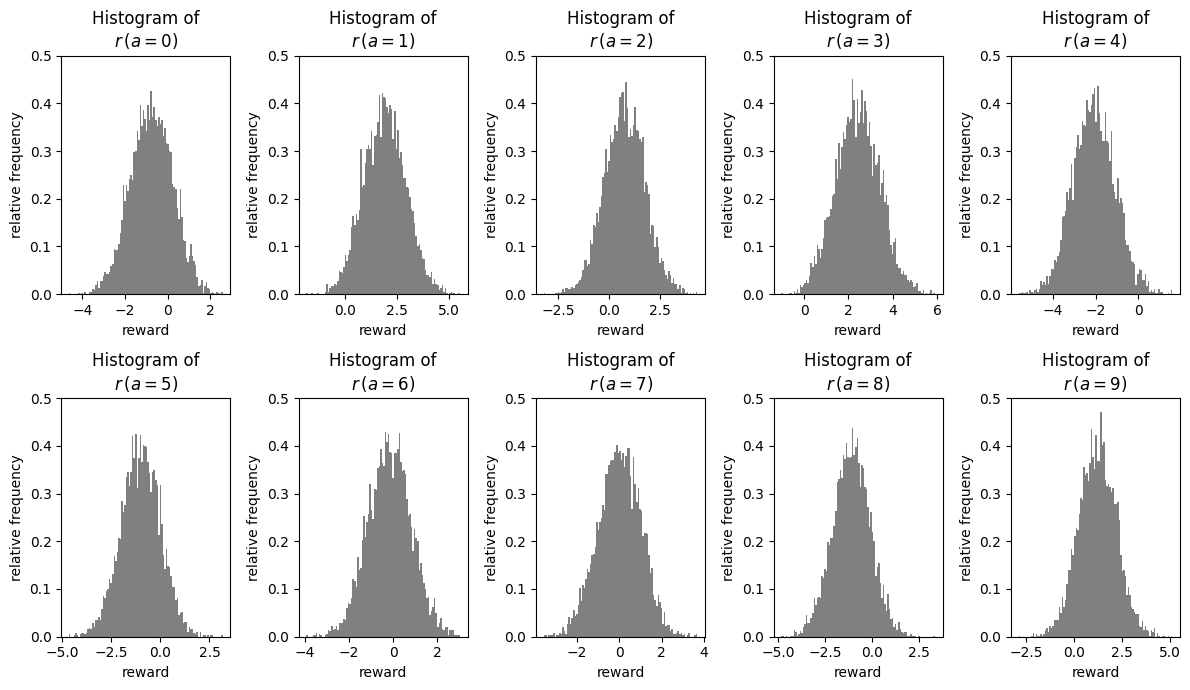

In [108]:
# samples each action and plots a histogram based on the rewards emitted
n_samples_per_action = 5000
n_cols = 5
n_rows = int(env.k / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 7))

for action, ax in enumerate(axs.flat):
  draws = [env.step(action) for _ in range(n_samples_per_action)]
  ax.hist(draws, bins=100, density=True, color='gray')
  ax.set_ylim(0, 0.5)
  ax.set_title(f"Histogram of\n$r\\,(a={action})$")

  ax.set_xlabel('reward')
  ax.set_ylabel('relative frequency')

plt.tight_layout()

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Based on the plots above, which actions do you think have the *best* and *worst* expected rewards?**

In [109]:
# set the values for the best and worst levers (actions) below
a_best = 3
a_worst = 0

### Sample-Averages, $Q_t(a)$

Now, let's estimate the value of each action using their *sample-average*, $Q_t(a)$.

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Take a moment to review the sample-average calculation that was given in equation (2.1) on p.27 of Sutton & Barto, 2020.**

We'll start by generating a random *trajectory* of actions and their associated rewards.

In [110]:
n = 100000
rng = np.random.default_rng()

# randomly select n actions and map them onto sampled rewards
actions = rng.choice(env.actions, n)
rewards = np.array(list(map(env.step, actions)))

# construct a trajectory of n timesteps
trajectory = np.column_stack((actions, rewards))

Run the next line to see the first few timesteps of the generated trajectory.

Notice that each element of the trajectory contains a pair of values: the action and reward that occurred at that timestep.

In [111]:
trajectory[0:10]

array([[ 8.        , -2.29747093],
       [ 1.        ,  1.17204437],
       [ 6.        ,  1.14616622],
       [ 9.        ,  2.27549686],
       [ 9.        ,  1.10025745],
       [ 8.        , -0.16723279],
       [ 8.        , -0.72789294],
       [ 2.        ,  1.14340354],
       [ 1.        ,  2.48001538],
       [ 0.        , -1.6608253 ]])

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Now, implement the `calculate_sample_averages()` function given below.**

In [112]:
def calculate_sample_averages(traj, actions):
  """ Calculates the sample averages for a given trajectory.

  Args:
    traj: a trajectory of (action, reward) pairs for each time step
    actions: the set of actions supported by this environment

  Returns:
    an array of sample-averages (one value for each action in actions)
  """
  sums = {a: 0.0 for a in actions}
  counts = {a: 0 for a in actions}

  for action, reward in traj:
    sums[int(action)] += reward
    counts[int(action)] += 1

  averages = []
  for a in actions:
    if counts[a] > 0:
      averages.append(sums[a] / counts[a])
    else:
      averages.append(0.0)

  return np.array(averages)

In [113]:
# generates the sample averages
Qt_sample = calculate_sample_averages(trajectory, actions=env.actions)

Now let's plot the sample-averages on the histograms we generated earlier.

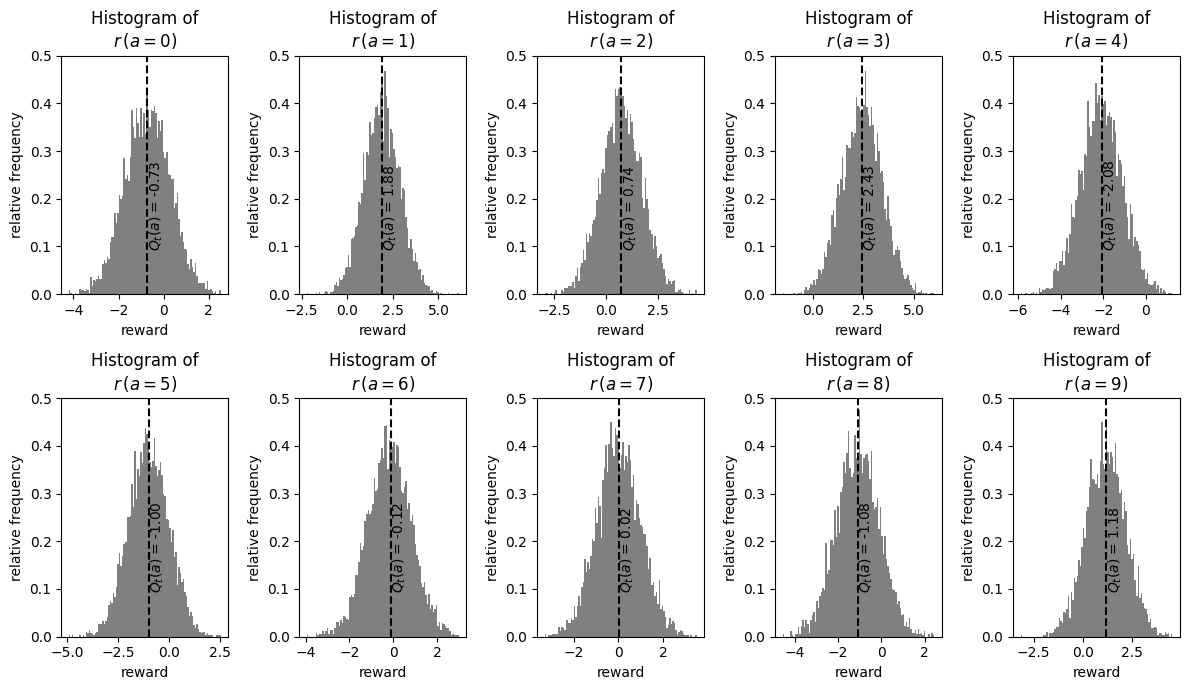

In [114]:
# samples each action and plots a histogram based on the rewards emitted
n_samples_per_action = 5000
n_cols = 5
n_rows = int(env.k / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 7))

for action, ax in enumerate(axs.flat):
  draws = [env.step(action) for _ in range(n_samples_per_action)]
  ax.hist(draws, bins=100, density=True, color='gray')
  ax.set_ylim(0, 0.5)
  ax.set_title(f"Histogram of\n$r\\,(a={action})$")

  ax.set_xlabel('reward')
  ax.set_ylabel('relative frequency')

  ax.axvline(x = Qt_sample[action], color='black', linestyle='--')
  ax.text(Qt_sample[action], 0.1,
          f'$Q_t(a)$ = {Qt_sample[action]:.2f}',
          rotation=90,
          color='black')

plt.tight_layout()

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Do the vertical lines in the histograms above align with the mean of the normal distribution for each action?**

(If not, your implementation may need to be revised!)

According to the sample averages we just calculated, the best and worst actions are:

In [115]:
print(f'a_best = {np.argmax(Qt_sample)}')
print(f'a_worst = {np.argmin(Qt_sample)}')

a_best = 3
a_worst = 4


**Was your previous guess correct?**

## The Agent

Now let's implement an agent that can learn to solve instances of the $k$-armed bandit problem.

**Solution Idea: A Value-Based Multi-Armed Bandit Agent**

If $q_*(a)$ were known for all $a\in\mathscr{A} = \{0,\ldots,k-1\}$, then an agent could simply choose its next action, $A_t$, as the one associated with the greatest expected reward.

That is, we could select the agent's action such that

$$A_t = \arg \max_a q_*(a).$$

Unfortunately, $q_*(a)$ is *not known* to the agent.

That said, we can *estimate* the action-value function, $q_*(a)$, based on the agent's environmental interactions (similar to how we calculated the *sample-averages* in the previous section, but *incrementally*).

That is, we will define a function $Q_t(a): \mathscr{A} \rightarrow \mathbb{R}$ and update that function each timestep based on the action selected and the rewards observed.

Given enough experience, $Q_t(a) \approx q_*(a)$ as $t\to\infty$.

This realization leads to a simple idea for solving the $k$-armed bandit problem:

1. Estimate $Q_t(a)$ based on the agent's environmental interactions (immediate rewards received).
2. Choose action $A_t = a$ using a policy based on $Q_t(a)$.

We call this kind of agent a **value-based agent**.

Our value-based agent needs the following components:

1. a **value function** `Qt`,
2. an **action selection strategy** for choosing actions based on `Qt`, and
3. an **update rule** to improve `Qt`'s estimates of $q_*(a)$ through experience (that is, to learn).

You will implement each of these components in the sections that follow.

### Value Function

The estimated action-value function $Q_t(a)$ maps $k$ actions onto estimates of $q_*(a),\;\forall a\in\{0,\ldots,k-1\} = \mathscr{A}$.

An efficient data structure for implementing $Q_t(a)$ is a [NumPy](https://numpy.org/doc/) array.


<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**In the cell below, define `Qt` as a numpy array (ndarray) with shape `(env.k,)` and initialize all of its elements to zero.**

In [116]:
# set the right-hand side to the appropriate value
Qt = np.zeros(env.k,)

### Action Selection

In general, the selection of actions depends on an agent's *state*, since the same action may be good when taken in one situation but not in others.

However, for multi-armed bandit problems, *there is only a single state*. Therefore, actions depend solely on $Q_t(a)$.

In the next section, you will implement several **action selection** functions:

1. `random_selection()`,
2. `greedy_selection()`, and
3. `epsilon_greedy_selection()`.

The `random_selection()` function, when implemented, should select an action from among the agent's $k$ actions using a (uniform) random distribution.

The `greedy_selection()` function, when implemented, should select the action that is currently believed to have the greatest expected reward, based on $Q_t$. *In the event of a tie, randomly choose among those maximal actions (using a uniform distribution).*

The `episilon_greedy_selection()` function, when implemented, should select a random action with probability $\epsilon$ (epsilon) and a greedy action with probability (1 - $\epsilon$). Note that the `episilon_greedy_selection()` function should behavior exactly like the `random_selection()` function when $\epsilon = 1$ and the `greedy_selection()` function when $\epsilon = 0$.

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Complete the implementation of each of the action selection strategies listed below.**

In [117]:
def random_selection(Qt):
  """ selects an action randomly from a uniform random distribution

  Args:
    Qt: the action-value function (ndarray)

  Returns:
    the selected action a, where 0 <= a <= k-1
  """
  # YOUR CODE HERE
  import random
  return random.randint(0, len(Qt)-1)

In [118]:
def greedy_selection(Qt):
  """ selects the best known action based on Qt.

  Ties are broken by selecting between max values using a uniform random
  selection.

  Args:
    Qt: the action-value function (ndarray)

  Returns:
    the selected action a, where 0 <= a <= k-1
  """
  best = 0
  # YOUR CODE HERE
  for i in range(len(Qt)):
    if Qt[i] > best: best = Qt[i]
    elif Qt[i] == best: return random_selection(Qt)
  return int(best)

**Now use the above functions to implement an $\epsilon$-greedy action selection strategy.**

In [119]:
def epsilon_greedy_selection(Qt, eps):
  """ selects a random action with epsilon probability; greedy otherwise.

  Args:
    Qt: the action-value function (ndarray)
    eps: an epsilon value (0.0 <= eps <= 1.0)

  Returns:
    the selected action a, where 0 <= a <= k-1
  """
  # YOUR CODE HERE
  if random_selection(Qt) < eps:
    return int(random_selection(Qt))
  else:
    return int(greedy_selection(Qt))


Testing the Action Selection Functions

In [120]:
# a test Qt function (evenly spaced action values)
Qt_test = np.linspace(-3.0, 3.0, env.k)

# duplicating maximal value to test greedy tie-breaker logic
Qt_test[-2] = Qt_test[-1]

In [121]:
# utility function
def generate_action_selection_histogram(Qt, k, n, strategy, title=''):
  """ Generates a histogram for an action selection strategy

  Args:
    Qt: action-values (iterable)
    k: the number of actions (int)
    n: the number of selections to sample from strategy (int)
    strategy: an action selection strategy that depends on Qt (callable)
    title: a title for the plot (optional)
  """
  selections = [strategy(Qt) for _ in range(n)]

  plt.hist(selections, bins=np.arange(k + 1)-0.5, color='gray', edgecolor='black')
  plt.title(title)

  plt.xticks(range(k))
  plt.yticks(np.linspace(0, n / 2, 11))

  plt.xlabel('Action')
  plt.ylabel('Frequency')

  plt.show()

The histogram for greedy selection should be approximately evenly distributed
between actions $k-1$ and $k-2$.

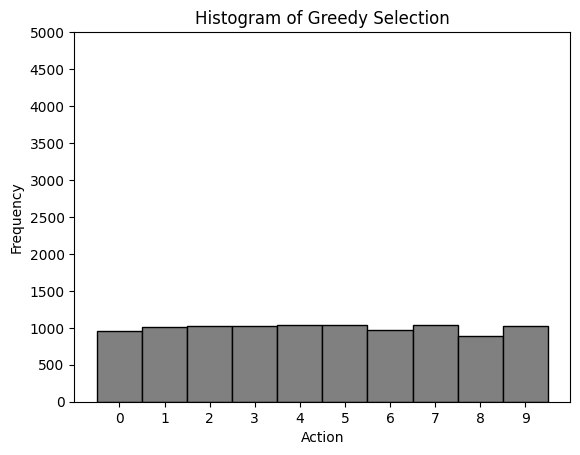

In [122]:
# testing greedy action selection
#################################
generate_action_selection_histogram(Qt=Qt_test, k=env.k, n=10000,
                                    strategy=greedy_selection,
                                    title='Histogram of Greedy Selection')

The histogram for random selection should be approximately evenly distributed
between all actions.

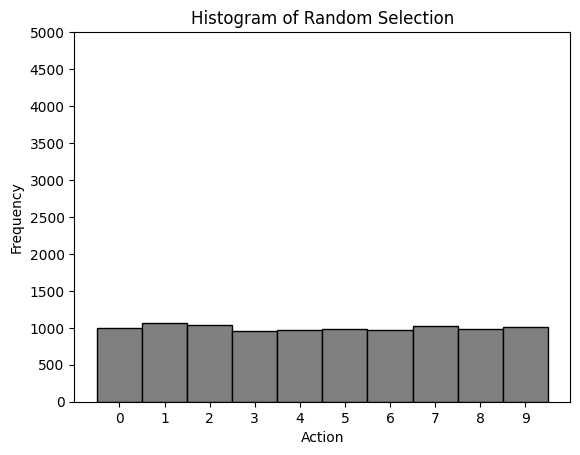

In [123]:
# testing random action selection
#################################
generate_action_selection_histogram(Qt=Qt_test, k=env.k, n=10000,
                                    strategy=random_selection,
                                    title='Histogram of Random Selection')

Below is a series of histograms that shows the frequency of selected actions for different epsilon values ($0.0 \le \epsilon \le 1.0$).

If `epsilon_greedy_action_selection` is implemented properly, then:

1. The plot for $\epsilon=0.0$ should look like greedy action selection.
2. The plot for $\epsilon=1.0$ should look like random action selection.
3. All other values should be on a continuum between these extremes, with
   values clustering towards $a=k-1$ and $a=k-2$ as $\epsilon \to 0.0$.

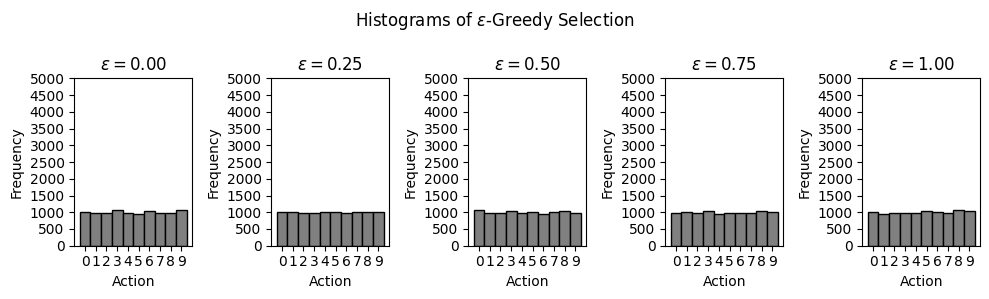

In [124]:
# plotting a set of histograms for epsilon greedy action selection with
# different epsilon values
eps_values = np.linspace(0.0, 1.0, 5)
k = env.k
Qt = Qt_test
n = 10000

fig, axs = plt.subplots(1, 5, figsize=(10, 3))
fig.suptitle('Histograms of $\\epsilon$-Greedy Selection')

for i, ax in enumerate(axs.flat):
  strategy = functools.partial(epsilon_greedy_selection, eps=eps_values[i])
  selections = [strategy(Qt) for _ in range(n)]

  ax.hist(selections, bins=np.arange(k + 1) - 0.5, color='gray', edgecolor='black')

  ax.set_title(f'$\\epsilon={eps_values[i]:.2f}$')

  ax.set_xticks(range(k))
  ax.set_yticks(np.linspace(0, n / 2, 11))

  ax.set_xlabel('Action')
  ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Learning

Now we're ready to implement an **incremental** learning algorithm to update our action-value `Qt` estimates.

**First, take a moment to familiarize yourself with the update rule introduced on p.32 of Sutton & Barto, 2020.**

Notice that we need to update two functions: `Qt(a)` and `N(a)`.

1. `N(a)` tracks the number of times that an action was selected.
2. `Qt(a)` estimates the action-value function $q_*(a)$.

Our update rule for `Qt(a)` depends on `N(a)`.

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Implement the `update` function (below) based on the "simple bandit algorithm" shown in Sutton & Barto, 2020, p. 32.**  

* You can assume that both `Qt` and `Na` were initialized elsewhere.
* The `update()` function's `history` argument contains the entire trajectory of (action, reward) pairs up to that timestep. The last element of that array contains the latest (action, reward).

Once you've implemented `update()`, run the test case in the cell that follows to check your work.

In [125]:
def update(Qt, Na, history):
  """ Updates the estimated action-value function (Qt) and action counts (Na).

  Args:
    Qt: estimated action-value function (ndarray)
    Na: number of times each action was selected (ndarray)
    history: a trajectory of actions and rewards, one pair per timestep

  Returns:
    None
  """
  # YOUR CODE HERE!
  action, reward = history[-1]
  Na[action] += 1
  Qt[action] += (reward - Qt[action]) / (Na[action])


In [126]:
class TestUpdate(unittest.TestCase):

    def test(self):
      Qt = np.zeros(env.k)
      Na = np.zeros(env.k)

      history = [
          [1, 1],
          [3, 0],
          [2, -1],
          [2, 0],
          [3, 1],
          [1, 3],
          [2, -2],
      ]

      for end in range(1, len(history) + 1):
        update(Qt, Na, history[:end])

      self.assertListEqual([0, 2, 3, 2, 0, 0, 0, 0, 0, 0], list(Na))
      self.assertListEqual([0, 2.0, -1, 0.5, 0, 0, 0, 0, 0, 0], list(Qt))

# executes the test case
unittest.main(argv=[''], verbosity=0, exit=False)

----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


Now let's try the update rule in the context of the multi-armed-bandit problem!

The `run()` function defined below runs one complete episode, terminating
when the agent's `budget` is exausted.

In [127]:
def run(env, Qt, Na, action_selection, update, budget):
  """ Runs an episode of the multi-armed bandit problem.

  The episode terminates when the agent's budget (B) has been exhausted.

  Args:
    env: an instance of the environment (MultiArmedBanditEnv)
    Qt: estimated action-value function (ndarray)
    Na: number of times each action was selected (ndarray)
    action_selection: a function that returns the agent's next action
    update: a function that updates Qt and Na
    budget: a positive integer that represents the number of allowed actions

  Returns:
    a single episode's trajectory (sequence of actions and rewards)
  """
  episode = []   # the trajectory for this episode
  t = 0   # current timestep

  while t < budget:

    # select an action
    action = action_selection(Qt)

    # generate an immediate reward
    reward = env.step(action)

    # update episode's history with latest (action, reward) pair
    episode.append((action, reward))

    # update action-value function
    update(Qt, Na, episode)

    # increment timestep
    t += 1

  return np.array(episode)

In [128]:
# initialize Qt and Na
Qt = np.zeros(env.k)
Na = np.zeros(env.k)

# functools is used here because k_armed_bandit expects an action selection
# function that only takes a single value (Qt)
action_selection = functools.partial(epsilon_greedy_selection, eps=0.1)

# run a single episode with a budget of 10000 actions
episode = run(env, Qt, Na, action_selection, update, budget=10000)

Check the distribution of selected actions, `Na`. Does it make sense based on the action selection method that you used?

In [129]:
Na

array([  96.,  110., 9032.,  104.,  100.,  112.,  104.,  122.,  117.,
        103.])

Next, look at the difference between `Qt` and `Qt_sample` that we calculated earlier.

Do the values match? If not, why do you think this is?

In [130]:
np.abs(Qt - Qt_sample)

array([0.37832409, 0.06932759, 0.02363283, 0.05552173, 0.31480561,
       0.04213743, 0.01926416, 0.08288507, 0.00922785, 0.12481608])

## Experiment

Once you're convinced that the algorithm is working correctly, let's try to replicate the 10-armed bandit experiment from Sutton & Barto in Section 2.3.

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Familiarize yourself with their experimental results by reading Section 2.3 and, in particular, looking at Figure 2.2 on p. 29**

In [131]:
# experiment parameters (10-armed bandit)
#########################################
env = MultiArmedBanditEnv(k=10, q_star_range=(-3.0, 3.0), stddev=1.0)
budget = 1000
n_episodes = 2000

# all action selection strategies to plot
selection_strategies = {
  'eps=1.0': functools.partial(epsilon_greedy_selection, eps=1.0),
  'eps=0.1': functools.partial(epsilon_greedy_selection, eps=0.1),
  'eps=0.01': functools.partial(epsilon_greedy_selection, eps=0.01),
  'eps=0.0': functools.partial(epsilon_greedy_selection, eps=0.0),
}

**WARNING: The next cell may take *a while* to run!!!**

In [132]:
# a dictionary containing results for each strategy
#    (key: strategy name, value: episode array)
results = {name:list() for name in selection_strategies}

for name, strategy in selection_strategies.items():
  print(f'running experiment for {name} strategy\n')

  # run all episodes
  for _ in range(n_episodes):

    # initialize value function and counter
    Qt = np.zeros(k)
    Na = np.zeros(k)

    # run a single episode
    episode = run(env, Qt, Na, strategy, update, budget)

    # save episode to results
    results[name].append(episode)

running experiment for eps=1.0 strategy

running experiment for eps=0.1 strategy

running experiment for eps=0.01 strategy

running experiment for eps=0.0 strategy



Now we need to implement two utility functions to present our results in the format used by Sutton & Barto.

* The first function, `calc_average_reward_per_step()`, calculates the average rewards for each time step *across all episodes* of a given strategy.
* The second function, `calc_percentage_optimal_action_per_step()`, calculates the percentage of the selected actions that were optimal for each time step.

I will implement the first function for you and walk you through the necessary NumPy calculations step-by-step.

*You must implement the second function and generate the plot of the results.*

### Average Reward Per Step

Let's start by examining the data structure we generated above by executing each of the cell below.

In [133]:
# a single strategy to index on
strategy_name='eps=0.1'

In [134]:
# single episode shape=(n steps, 2 columns [actions and rewards])
episode = results[strategy_name][1]
episode.shape

(1000, 2)

In [135]:
# all rewards from a single episode for a single strategy
rewards_for_episode = episode[:,1]
rewards_for_episode.shape

(1000,)

In [136]:
# all rewards over all episodes (for a single strategy)
rewards_for_all_episodes = np.vstack([episode[:,1] for episode in results[strategy_name]])
rewards_for_all_episodes.shape

(2000, 1000)

In [137]:
# calculating the average rewards per step across all episodes (for a single strategy)
avg_rewards_per_step = np.mean(rewards_for_all_episodes, axis=0)
avg_rewards_per_step.shape

(1000,)

Now, putting all of this together, we have the implementation for the first function.

In [138]:
def calc_average_reward_per_step(episodes):
  """ Calculates the average reward per time step.

  Results are calculated across all episodes.

  Args:
    episodes: an array of episodes rewards [shape=(n_episodes, n_timesteps)]

  Returns:
    an array of average rewards per step [shape=(n_timesteps,)]
  """
  rewards = np.vstack([e[:,1] for e in episodes])
  return np.mean(rewards, axis=0)

In [139]:
# a dictionary that will contain the average rewards per step for each strategy
#    (key: strategy name, value: average rewards per timestep)
avg_rewards = dict()

# calculate the average rewards (one loop iteration for each strategy)
for strategy, episodes in results.items():
  avg_rewards[strategy] = calc_average_reward_per_step(episodes)

#### Figure: Average Reward vs. Steps
Finally, let's plot our average rewards using a similar format to what Sutton & Barto used in Figure 2.2 (top plot)

Note: We've added one more data set for completely random action selection (eps = 1.0) that was not in Sutton & Barto.

<Figure size 640x480 with 0 Axes>

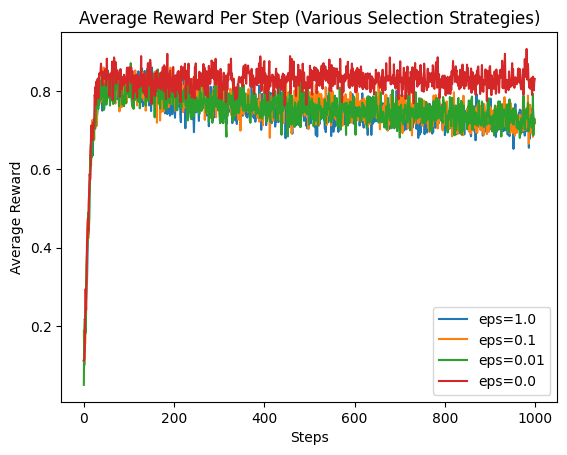

In [140]:
fig = plt.figure()
x = np.linspace(0, 1000, 200)
fig, ax = plt.subplots()

# generate plots for each strategy
for name, r_per_step in avg_rewards.items():
  ax.plot(r_per_step, label=name)

ax.set_xlabel('Steps')
ax.set_ylabel('Average Reward')

ax.set_title("Average Reward Per Step (Various Selection Strategies)")
ax.legend()

plt.show()

### % Optimal Action Per Step

Now it's your turn!

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Determine the optimal actions for this instance of the environment using the techniques introduced in this lab (e.g., sample-averages).**

In [141]:
# calculate the array of optimal actions!
optimal_actions = np.zeros(env.k)

# YOUR CODE HERE!
best_action = np.argmax(Qt)
optimal_actions = best_action

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Implement the `calc_percentage_optimal_action_per_step()` function below.**

In [142]:
def calc_percentage_optimal_action_per_step(episodes, optimal_actions):
  """ Calculates the percentage of actions that were optimal at each time step.

  Results are calculated across all episodes.

  Args:
    episodes: an array of episodes rewards [shape=(n_episodes, n_timesteps)]
    optimal_actions: an array of optimal actions for this problem

  Returns:
    an array of percentages (0-100%) per step [shape=(n_timesteps,)]
  """
  # YOUR CODE HERE!
  correct = (episodes == optimal_actions)

  percentages = correct.mean(axis=0) * 100

  return percentages

In [143]:
# a dictionary that will contain the % optimal actions per step for each strategy
#    (key: strategy name, value: % optimal actions per timestep)
percent_optimal = dict()

# calculate the % optimal actions per step (one loop iteration for each strategy)
for strategy, episodes in results.items():
  percent_optimal[strategy] = calc_percentage_optimal_action_per_step(
      episodes, optimal_actions)

#### Figure: % Optimal Action vs. Steps
<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Generate a plot that shows "% Optimal Action vs Steps" in a format that is similar to Sutton & Barto Figure 2.2 (bottom plot).**

Make sure to plot the curves for *all* strategies in a single figure.

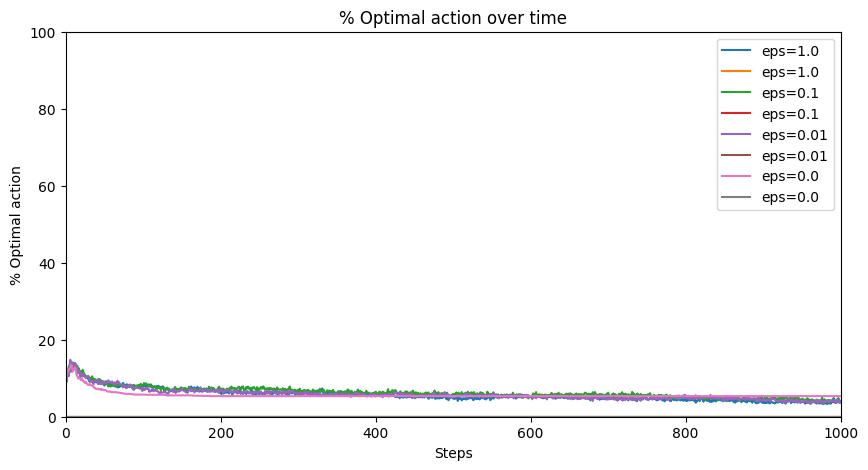

In [144]:
# add code to generate a figure using matplotlib

# YOUR CODE HERE!
import matplotlib.pyplot as plt
import numpy as np

# Plot each strategy
plt.figure(figsize=(10, 5))

for strategy, percentages in percent_optimal.items():
    plt.plot(percentages, label=strategy)

# Labels and formatting
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.ylim(0, 100)
plt.xlim(0, len(next(iter(percent_optimal.values()))))
plt.legend()
plt.title("% Optimal action over time")

plt.show()

## Parameter Optimization

Now that you have a working algorithm and have successfully completed our first experiment on the multi-armed bandit environment, let's try to optimize the parameters!

### Epsilon

In the experiment above, we tried out several different epsilon ($\epsilon$) values for our epsilon-greedy action selection function.

If your implementation is correct, you should have noticed that $\epsilon=0.1$ performed better than $\epsilon=0.01$ given the problem's budget of 1000 actions.

But what is the best value of $\epsilon$ to use for this problem?

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Try out different values and build a case for the best epsilon value given a fixed budget.**

*Use figures to support your case.*

In [146]:
# find the best epsilon value!

# YOUR CODE HERE!
#tihs was super hard. I struggled very greatly with this. I am super sorry I
#didnt get it done. very dissapointed in myself :(

# --- Plotting ---

# Plot % optimal action
plt.subplot(1, 2, 1)
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.ylim(0, 100)
plt.title("% Optimal action over time")
plt.legend()

# Plot average reward
plt.subplot(1, 2, 2)

plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.title("Average reward over time")
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'EpsilonGreedyAgent' is not defined

### Step Size (EXTRA CREDIT)

In the learning algorithm developed earlier in the lab, we used a step size based on $N(a)$. This allowed us to calculate the sample-average incrementally.

However, a consequence of this method of calculating the step size is that the learning rate *decreases* over time.

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Try to speed up learning by reimplementing the earlier learning algorithm using a different strategy for choosing the step size.**





In [ ]:
# extra credit: improve the learning algorithm!
#   (without changing the previous learn function!)

# YOUR CODE HERE!

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**Generate figures comparing the two algorithms (original and improved).**

In [ ]:
# extra credit: generate figures to compare the algorithms

# YOUR CODE HERE!

<img src="https://img.freepik.com/premium-vector/scientist-professor-holding-stop-sign_20412-3130.jpg" width="225" height="200">

**What are the consequences of this change in terms of the algorithms convergence?**

`<YOUR ANSWER HERE>`